In [1]:
from github import Github
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

ROLLING_WINDOW = 5

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio', 'Date',
       'Incidence_Rate', 'Case-Fatality_Ratio'],
      dtype='object')


FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2020-12-10 05:26:19  33.93911   
1   NaN    NaN            NaN        Albania  2020-12-10 05:26:19  41.15330   

       Long_  Confirmed  Deaths  Recovered   Active Combined_Key  \
0  67.709953    47851.0  1919.0    38032.0   7900.0  Afghanistan   
1  20.168300    45188.0   951.0    23072.0  21165.0      Albania   

   Incident_Rate  Case_Fatality_Ratio       Date  Incidence_Rate  \
0     122.920728             4.010366 2020-12-09             NaN   
1    1570.227257             2.104541 2020-12-09             NaN   

   Case-Fatality_Ratio  
0                  NaN  
1                  NaN

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    9042
unique                    274
top       2020-09-01 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-12-09 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incident_Rate  Case_Fatality_Ratio       Date  Incidence_Rate  \
211            NaN                  NaN 2020-03-12             NaN   
212            NaN

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     274
unique                    274
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-12-09 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     294
unique                    294
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-12-09 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS                Admin2         Province_State Country_Region  \
214       NaN                   NaN                    NaN         France   
577       NaN                   NaN                    NaN    Saint Lucia   
2441  32011.0                Eureka                 Nevada             US   
214       NaN                   NaN                    NaN         France   
2414  31147.0            Richardson               Nebraska             US   
...       ...                   ...                    ...            ...   
3186      NaN                   NaN   Prince Edward Island         Canada   
3187      NaN                   NaN  Northwest Territories         Canada   
3188      NaN                   NaN       Diamond Princess         Canada   
3415  11001.0  District of Columbia   District of Columbia             US   
3416  53023.0       Garfield County             Washington             US   

              Last_Update        Lat       Long_  Confirmed   Deaths  \
214   2020-12-10 05:26:19  46.227600    2.213700  2321996.0  56293.0   
577   2020-12-10 05:26:19  13.909400  -60.978900      270.0      2.0   
2441  2020-12-10 05:26:19  39.981009 -116.268320       25.0      0.0   
214   2020-12-09 05:28:01  46.227600    2.213700  2307870.0  56001.0   
2414  2020-12-09 05:28:01  40.124741  -95.717550      410.0      3.0   
...                   ...        ...         ...        ...      ...   
3186        3/22/20 23:48  46.510700  -63.416800        3.0      0.0   
3187        3/22/20 23:48        NaN         NaN        1.0      0.0   
3188        3/22/20 23:48   0.000000    0.000000        0.0      1.0   
3415        3/22/20 23:45  38.904178  -77.016560      102.0      2.0   
3416        3/22/20 23:45  46.451975 -117.545403        1.0      2.0   

      Recovered     Active                                  Combined_Key  \
214    150219.0  2115343.0                                        France   
577       169.0       91.0                                   Saint Lucia   
2441        0.0        0.0                            Eureka, Nevada, US   
214    148840.0  2102931.0                                        France   
2414        0.0      409.0                      Richardson, Nebraska, US   
...         ...        ...                                           ...   
3186        0.0        0.0                  Prince Edward Island, Canada   
3187        0.0        0.0                 Northwest Territories, Canada   
3188        0.0        0.0                      Diamond Princess, Canada   
3415        0.0        0.0  District of Columbia,District of Columbia,US   
3416        0.0        0.0                 Garfield County,Washington,US   

      Incident_Rate  Case_Fatality_Ratio       Date  Incidence_Rate  \
214     3557.115174             2.424337 2020-12-09             NaN   
577      147.580175             0.740741 2020-12-09             NaN   
2441       0.000000             0.000000 2020-12-09             NaN   
214     3535.538275             2.426523 2020-12-08             NaN   
2414    5314.685315             0.731707 2020-12-08             NaN   
...             ...                  ...        ...             ...   
3186            NaN                  NaN 2020-03-22             NaN   
3187            NaN                  NaN 2020-03-22             NaN   
3188            NaN                  NaN 2020-03-22             NaN   
3415            NaN                  NaN 2020-03-22             NaN   
3416            NaN                  NaN 2020-03-22             NaN   

      Case-Fatality_Ratio  
214                   NaN  
577                   NaN  
2441                  NaN  
214                   NaN  
2414                  NaN  
...                   ...  
3186                  NaN  
3187                  NaN  
3188                  NaN  
3415                  NaN  
3416                  NaN  

[66411 rows x 17 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53024 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            53024 non-null  float64
 1   Deaths               53024 non-null  float64
 2   Recovered            53024 non-null  float64
 3   Active               53024 non-null  float64
 4   Incident_Rate        53024 non-null  float64
 5   Case_Fatality_Ratio  53024 non-null  float64
 6   Incidence_Rate       53024 non-null  float64
 7   Case-Fatality_Ratio  53024 non-null  float64
dtypes: float64(8)
memory usage: 3.4+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incident_Rate  Case_Fatality_Ratio  Incidence_Rate  \
Country_Region Date                                                             
 Azerbaijan    2020-02-28            0.0                  0.0             0.0   
Afghanistan    2020-02-24            0.0                  0.0             0.0   
               2020-02-25            0.0                  0.0             0.0   
               2020-02-26            0.0                  0.0             0.0   
               2020-02-27            0.0                  0.0             0.0   

                           Case-Fatality_Ratio  
Country_Region Date                             
 Azerbaijan    2020-02-28                  0.0  
Afghanistan    2020-02-24                  0.0  
               2020-02-25                  0.0  
               2020-02-26                  0.0  
               2020-02-27                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'India', 'Brazil', 'Russia', 'France', 'United Kingdom', 'Italy',
       'Spain', 'Argentina', 'Colombia', 'Germany', 'Mexico', 'Poland', 'Iran',
       'Peru', 'Turkey', 'Ukraine', 'South Africa', 'Belgium', 'Indonesia',
       'Netherlands', 'Iraq', 'Chile', 'Czechia', 'Romania', 'Bangladesh',
       'Philippines', 'Canada', 'Pakistan', 'Morocco', 'Switzerland',
       'Saudi Arabia', 'Israel', 'Portugal', 'Austria', 'Sweden', 'Hungary',
       'Jordan', 'Nepal', 'Serbia', 'Ecuador', 'Panama', 'Kazakhstan',
       'United Arab Emirates', 'Georgia', 'Bulgaria', 'Japan', 'Croatia',
       'Azerbaijan', 'Belarus'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))
print()
print('\n'.join(c for c in population.index if 'Venezuela' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)

Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14624 entries, ('Argentina', Timestamp('2020-03-03 00:00:00')) to ('United Kingdom', Timestamp('2020-12-09 00:00:00'))
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            14624 non-null  float64
 1   Deaths               14624 non-null  float64
 2   Recovered            14624 non-null  float64
 3   Active               14624 non-null  float64
 4   Incident_Rate        14624 non-null  float64
 5   Case_Fatality_Ratio  14624 non-null  float64
 6   Incidence_Rate       14624 non-null  float64
 7   Case-Fatality_Ratio  14624 non-null  float64
 8   Confirmed_per_100k   14624 non-null  float64
 9   Deaths_per_100k      14624 non-null  float64
 10  Recovered_per_100k   14624 non-null  float64
 11  Active_per_100k      14624 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ MB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        1.0     0.0        0.0     1.0   
               2020-03-04        1.0     0.0        0.0     1.0   
               2020-03-05        1.0     0.0        0.0     1.0   
               2020-03-06        2.0     0.0        0.0     2.0   
               2020-03-07        8.0     0.0        0.0     8.0   

                           Incident_Rate  Case_Fatality_Ratio  Incidence_Rate  \
Country_Region Date                                                             
Argentina      2020-03-03            0.0                  0.0             0.0   
               2020-03-04            0.0                  0.0             0.0   
               2020-03-05            0.0                  0.0             0.0   
               2020-03-06            0.0                  0.0             0.0   
               2020-03-07            0.0                  0.0             0.0   

                           Case-Fatality_Ratio  Confirmed_per_100k  \
Country_Region Date                                                  
Argentina      2020-03-03                  0.0            0.002233   
               2020-03-04                  0.0            0.002233   
               2020-03-05                  0.0            0.002233   
               2020-03-06                  0.0            0.004466   
               2020-03-07                  0.0            0.017865   

                           Deaths_per_100k  Recovered_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03              0.0                 0.0   
               2020-03-04              0.0                 0.0   
               2020-03-05              0.0                 0.0   
               2020-03-06              0.0                 0.0   
               2020-03-07              0.0                 0.0   

                           Active_per_100k  
Country_Region Date                         
Argentina      2020-03-03         0.002233  
               2020-03-04         0.002233  
               2020-03-05         0.002233  
               2020-03-06         0.004466  
               2020-03-07         0.017865

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Argentina to United Kingdom
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incident_Rate            50 non-null     float64
 5   Case_Fatality_Ratio      50 non-null     float64
 6   Incidence_Rate           50 non-null     float64
 7   Case-Fatality_Ratio      50 non-null     float64
 8   Confirmed_per_100k       50 non-null     float64
 9   Deaths_per_100k          50 non-null     float64
 10  Recovered_per_100k       50 non-null     float64
 11  Active_per_100k          50 non-null     float64
 12  population               50 non-null     float64
 13  recovered_per_confirmed  50 non-null     float64
 14  deaths_per_co

Confirmed    Deaths  Recovered     Active  \
Country_Region                                                     
Argentina              1475222.0   40222.0  1311488.0   174335.0   
Austria                 311002.0    4056.0   265815.0    77130.0   
Azerbaijan              158555.0    1755.0    96330.0    60470.0   
Bangladesh              484104.0    6930.0   405966.0   115779.0   
Belarus                 152453.0    1230.0   129950.0    25477.0   
Belgium                 597643.0   17603.0    31130.0   580040.0   
Brazil                 6728452.0  178995.0  5966118.0   726064.0   
Bulgaria                171493.0    5283.0    72078.0    95442.0   
Canada                  439142.0   13009.0   355401.0    71785.0   
Chile                   564778.0   15690.0   539171.0    95631.0   
Colombia               1392133.0   38308.0  1287597.0   925831.0   
Croatia                 159372.0    2367.0   133255.0    24495.0   
Czechia                 556927.0    9136.0   489759.0   188492.0   
Ecuador                 199228.0   13814.0   174188.0    44283.0   
France                 2363688.0   56558.0   176456.0  2130674.0   
Georgia                 174383.0    1614.0   145287.0    27482.0   
Germany                1254358.0   20460.0   929272.0   317709.0   
Hungary                 259588.0    6280.0    76270.0   177038.0   
India                  9767371.0  141772.0  9253306.0  1017754.0   
Indonesia               592900.0   18171.0   487445.0    87284.0   
Iran                   1072620.0   51212.0   765639.0   259439.0   
Iraq                    569873.0   12501.0   499846.0    63157.0   
Israel                  350271.0    2934.0   332089.0    71114.0   
Italy                  1770149.0   61739.0   997895.0   805947.0   
Japan                   169429.0    2376.0   140466.0    26587.0   
Jordan                  250219.0    3206.0   202058.0   137385.0   
Kazakhstan              182657.0    2546.0   154432.0    34497.0   
Mexico                 1205229.0  111655.0   889168.0   204406.0   
Morocco                 388184.0    6427.0   341685.0    49800.0   
Nepal                   244433.0    1651.0   230537.0    46691.0   
Netherlands             586643.0    9923.0     7551.0   569169.0   
Pakistan                429280.0    8603.0   374301.0   108642.0   
Panama                  182977.0    3264.0   156870.0    25549.0   
Peru                    976621.0   36401.0   911113.0   168092.0   
Philippines             444164.0    8677.0   408942.0    83109.0   
Poland                 1088346.0   21160.0   768241.0   440035.0   
Portugal                332073.0    5192.0   254700.0    88854.0   
Romania                 532040.0   12821.0   425816.0   120307.0   
Russia                 2518551.0   44220.0  1989710.0   485175.0   
Saudi Arabia            359274.0    6002.0   349624.0    63026.0   
Serbia                  241831.0    2116.0    15564.0   239715.0   
South Africa            828598.0   22574.0   754658.0   173590.0   
Spain                  1712101.0   47019.0   150376.0  1514706.0   
Sweden                  304793.0    7296.0     4971.0   297497.0   
Switzerland             363654.0    5710.0   283000.0   139020.0   
Turkey                  925342.0   15531.0   447361.0   462450.0   
US                    15386562.0  289373.0  5889896.0  9207293.0   
Ukraine                 867991.0   14702.0   469200.0   388791.0   
United Arab Emirates    180150.0     598.0   161084.0    18468.0   
United Kingdom         1771545.0   62663.0     3778.0  1705104.0   

                      Incident_Rate  Case_Fatality_Ratio  Incidence_Rate  \
Country_Region                                                             
Argentina              3.264070e+03             2.726505    2.748447e+03   
Austria                3.453122e+03             1.304172    1.700491e+03   
Azerbaijan             1.563786e+03             1.295054    6.451314e+02   
Bangladesh             2.939497e+02             1.443872    2.551701e+02   
Belarus                1.61337

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                            
US                    15386562.0  289373.0
India                  9767371.0  141772.0
Brazil                 6728452.0  178995.0
Russia                 2518551.0   44220.0
France                 2363688.0   56558.0
United Kingdom         1771545.0   62663.0
Italy                  1770149.0   61739.0
Spain                  1712101.0   47019.0
Argentina              1475222.0   40222.0
Colombia               1392133.0   38308.0
Germany                1254358.0   20460.0
Mexico                 1205229.0  111655.0
Poland                 1088346.0   21160.0
Iran                   1072620.0   51212.0
Peru                    976621.0   36401.0
Turkey                  925342.0   15531.0
Ukraine                 867991.0   14702.0
South Africa            828598.0   22574.0
Belgium                 597643.0   17603.0
Indonesia               592900.0   18171.0
Netherlands             586643.0    9923.0
Iraq                    569873.0   12501.0
Chile                   564778.0   15690.0
Czechia                 556927.0    9136.0
Romania                 532040.0   12821.0
Bangladesh              484104.0    6930.0
Philippines             444164.0    8677.0
Canada                  439142.0   13009.0
Pakistan                429280.0    8603.0
Morocco                 388184.0    6427.0
Switzerland             363654.0    5710.0
Saudi Arabia            359274.0    6002.0
Israel                  350271.0    2934.0
Portugal                332073.0    5192.0
Austria                 311002.0    4056.0
Sweden                  304793.0    7296.0
Hungary                 259588.0    6280.0
Jordan                  250219.0    3206.0
Nepal                   244433.0    1651.0
Serbia                  241831.0    2116.0
Ecuador                 199228.0   13814.0
Panama                  182977.0    3264.0
Kazakhstan              182657.0    2546.0
United Arab Emirates    180150.0     598.0
Georgia                 174383.0    1614.0
Bulgaria                171493.0    5283.0
Japan                   169429.0    2376.0
Croatia                 159372.0    2367.0
Azerbaijan              158555.0    1755.0
Belarus                 152453.0    1230.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k   Confirmed    Deaths
Country_Region                                                
Czechia                      5210.177775    556927.0    9136.0
Belgium                      5179.184642    597643.0   17603.0
US                           4675.843946  15386562.0  289373.0
Georgia                      4363.106935    174383.0    1614.0
Panama                       4308.950556    182977.0    3264.0
Switzerland                  4232.786866    363654.0    5710.0
Israel                       4111.464541    350271.0    2934.0
Croatia                      3858.606847    159372.0    2367.0
Spain                        3663.283878   1712101.0   47019.0
France                       3629.199697   2363688.0   56558.0
Austria                      3472.900606    311002.0    4056.0
Netherlands                  3431.238109    586643.0    9923.0
Argentina                    3294.327296   1475222.0   40222.0
Portugal                     3247.283589    332073.0    5192.0
Brazil                       3188.091606   6728452.0  178995.0
Sweden                       3036.878495    304793.0    7296.0
Peru                         3004.020675    976621.0   36401.0
Chile                        2980.038819    564778.0   15690.0
Italy                        2923.445599   1770149.0   61739.0
Poland                       2872.552202   1088346.0   21160.0
Colombia                     2765.491466   1392133.0   38308.0
Serbia                       2756.779692    241831.0    2116.0
Romania                      2747.493643    532040.0   12821.0
Hungary                      2680.398320    259588.0    6280.0
United Kingdom               2623.338926   1771545.0   62663.0
Jordan                       2476.999657    250219.0    3206.0
Bulgaria                     2449.859052    171493.0    5283.0
Ukraine                      1972.991871    867991.0   14702.0
United Arab Emirates         1843.810661    180150.0     598.0
Russia                       1726.545541   2518551.0   44220.0
Belarus                      1612.848111    152453.0    1230.0
Azerbaijan                   1578.019847    158555.0    1755.0
Germany                      1501.918542   1254358.0   20460.0
Iraq                         1449.697428    569873.0   12501.0
South Africa                 1414.997476    828598.0   22574.0
Iran                         1293.655335   1072620.0   51212.0
Canada                       1173.830034    439142.0   13009.0
Ecuador                      1146.724607    199228.0   13814.0
Turkey                       1109.129041    925342.0   15531.0
Morocco                      1064.341113    388184.0    6427.0
Saudi Arabia                 1048.408001    359274.0    6002.0
Kazakhstan                    984.598059    182657.0    2546.0
Mexico                        944.718011   1205229.0  111655.0
Nepal                         854.400486    244433.0    1651.0
India                         714.815872   9767371.0  141772.0
Philippines                   410.819347    444164.0    8677.0
Bangladesh                    296.912213    484104.0    6930.0
Indonesia                     219.084991    592900.0   18171.0
Pakistan                      198.221953    429280.0    8603.0
Japan                         133.555574    169429.0    2376.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                  
Mexico                 1205229.0  111655.0              0.092642
Ecuador                 199228.0   13814.0              0.069338
Iran                   1072620.0   51212.0              0.047745
Peru                    976621.0   36401.0              0.037272
United Kingdom         1771545.0   62663.0              0.035372
Italy                  1770149.0   61739.0              0.034878
Bulgaria                171493.0    5283.0              0.030806
Indonesia               592900.0   18171.0              0.030648
Canada                  439142.0   13009.0              0.029624
Belgium                 597643.0   17603.0              0.029454
Chile                   564778.0   15690.0              0.027781
Colombia               1392133.0   38308.0              0.027517
Spain                  1712101.0   47019.0              0.027463
Argentina              1475222.0   40222.0              0.027265
South Africa            828598.0   22574.0              0.027244
Brazil                 6728452.0  178995.0              0.026603
Hungary                 259588.0    6280.0              0.024192
Romania                 532040.0   12821.0              0.024098
Sweden                  304793.0    7296.0              0.023938
France                 2363688.0   56558.0              0.023928
Iraq                    569873.0   12501.0              0.021936
Pakistan                429280.0    8603.0              0.020041
Philippines             444164.0    8677.0              0.019536
Poland                 1088346.0   21160.0              0.019442
US                    15386562.0  289373.0              0.018807
Panama                  182977.0    3264.0              0.017838
Russia                 2518551.0   44220.0              0.017558
Ukraine                 867991.0   14702.0              0.016938
Netherlands             586643.0    9923.0              0.016915
Turkey                  925342.0   15531.0              0.016784
Saudi Arabia            359274.0    6002.0              0.016706
Morocco                 388184.0    6427.0              0.016557
Czechia                 556927.0    9136.0              0.016404
Germany                1254358.0   20460.0              0.016311
Switzerland             363654.0    5710.0              0.015702
Portugal                332073.0    5192.0              0.015635
Croatia                 159372.0    2367.0              0.014852
India                  9767371.0  141772.0              0.014515
Bangladesh              484104.0    6930.0              0.014315
Japan                   169429.0    2376.0              0.014024
Kazakhstan              182657.0    2546.0              0.013939
Austria                 311002.0    4056.0              0.013042
Jordan                  250219.0    3206.0              0.012813
Azerbaijan              158555.0    1755.0              0.011069
Georgia                 174383.0    1614.0              0.009255
Serbia                  241831.0    2116.0              0.008750
Israel                  350271.0    2934.0              0.008376
Belarus                 152453.0    1230.0              0.008068
Nepal                   244433.0    1651.0              0.006754
United Arab Emirates    180150.0     598.0              0.003319

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate',
       'Case_Fatality_Ratio', 'Incidence_Rate', 'Case-Fatality_Ratio',
       'Confirmed_per_100k', 'Deaths_per_100k', 'Recovered_per_100k',
       'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

IndexError: index 2 is out of bounds for axis 1 with size 2

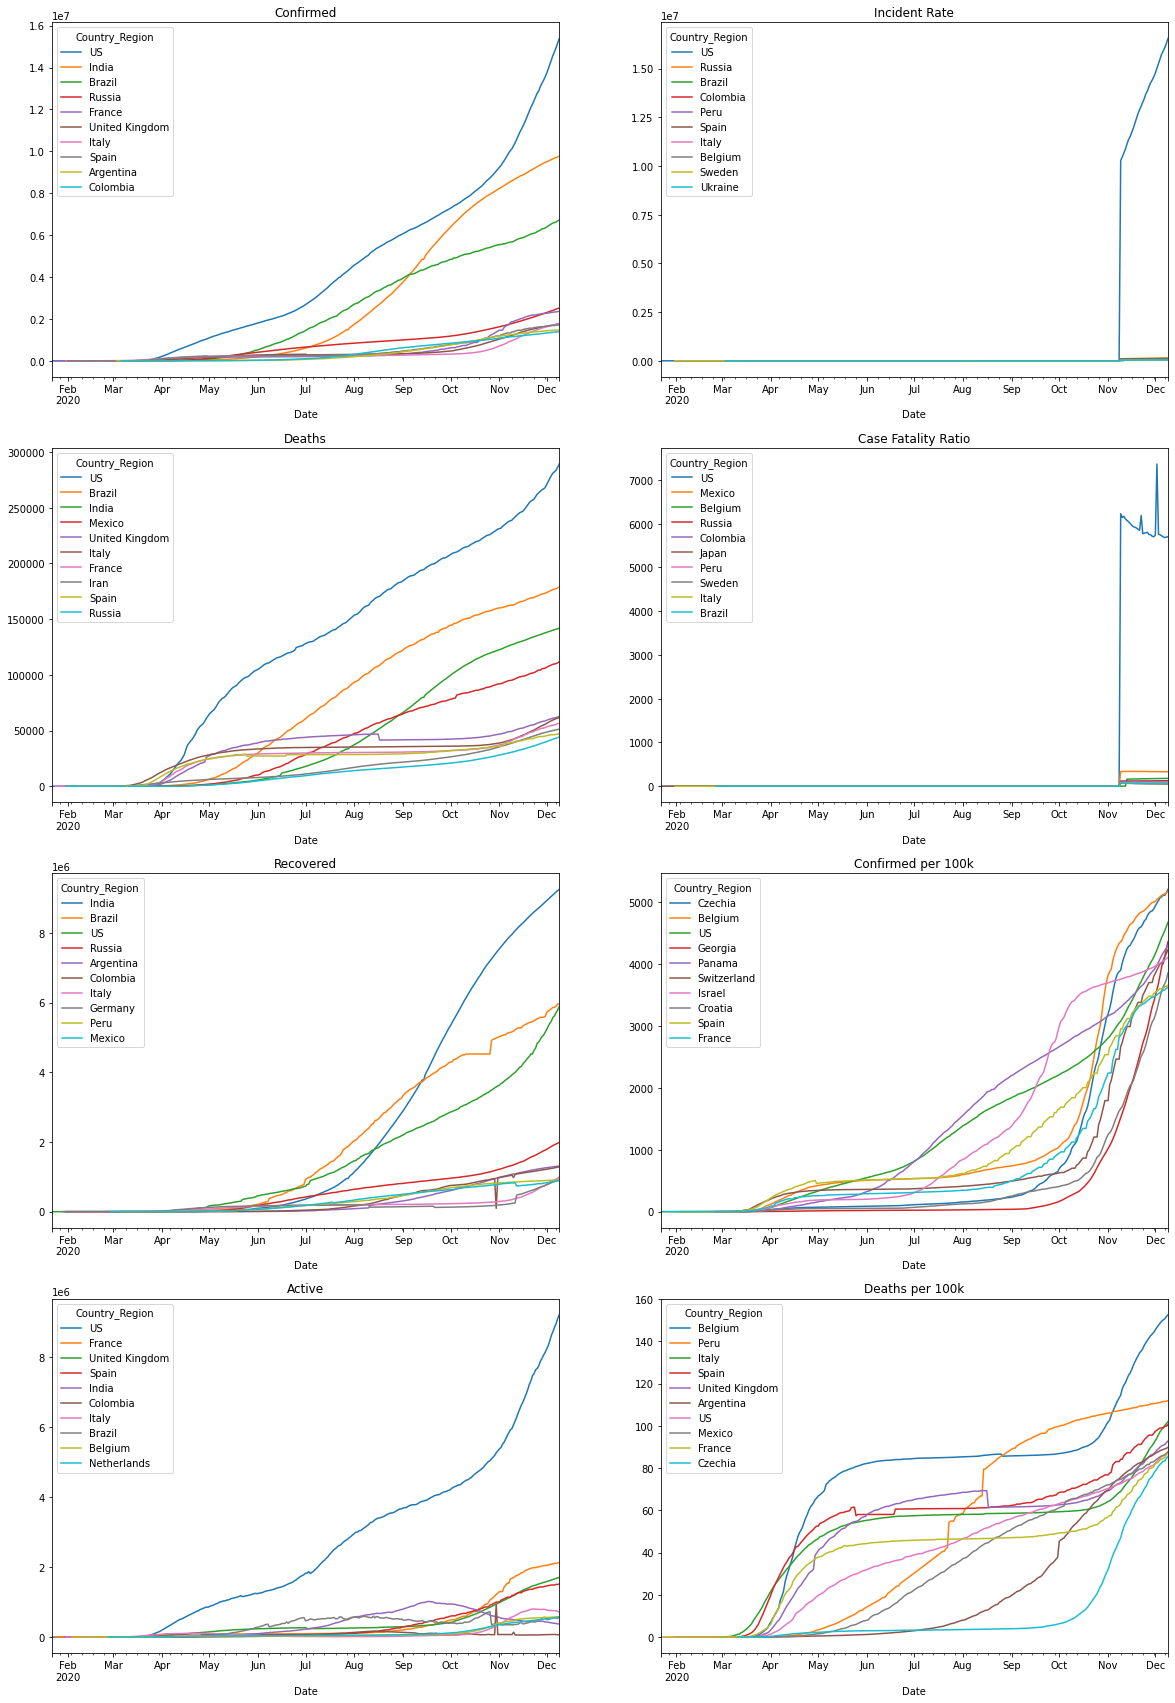

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

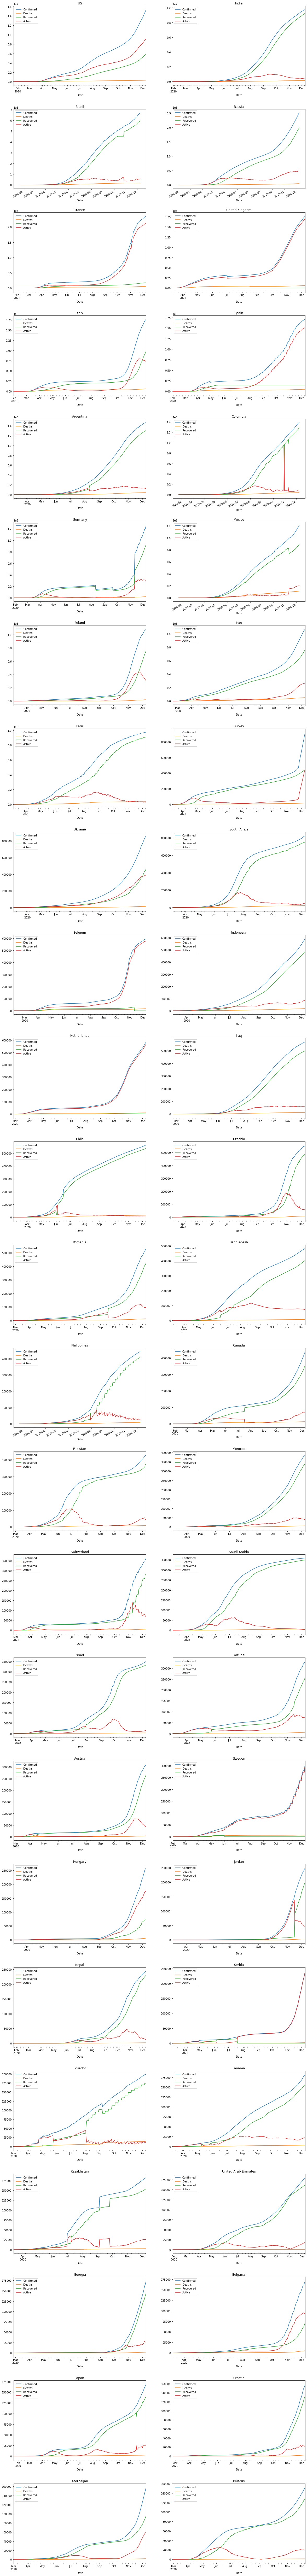

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=ROLLING_WINDOW).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Argentina      Argentina      2020-03-03        NaN     NaN        NaN   
                              2020-03-04        NaN     NaN        NaN   
                              2020-03-05        NaN     NaN        NaN   
                              2020-03-06        NaN     NaN        NaN   
                              2020-03-07        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-12-05    15329.2   513.2       16.0   
                              2020-12-06    16104.2   438.8       29.4   
                              2020-12-07    15811.6   347.0       29.0   
                              2020-12-08    15298.6   384.0       28.4   
                              2020-12-09    15349.0   389.8       28.2   

                                           Active  Incident_Rate  \
Country_Region Country_Region Date                                 
Argentina      Argentina      2020-03-03      NaN            NaN   
                              2020-03-04      NaN            NaN   
                              2020-03-05      NaN            NaN   
                              2020-03-06      NaN            NaN   
                              2020-03-07      NaN            NaN   
...                                           ...            ...   
United Kingdom United Kingdom 2020-12-05  14800.0     175.852094   
                              2020-12-06  15636.0     182.337496   
                              2020-12-07  15435.6     182.300128   
                              2020-12-08  14886.2     184.096654   
                              2020-12-09  14931.0     185.147702   

                                          Case_Fatality_Ratio  \
Country_Region Country_Region Date                              
Argentina      Argentina      2020-03-03                  NaN   
                              2020-03-04                  NaN   
                              2020-03-05                  NaN   
                              2020-03-06                  NaN   
                              2020-03-07                  NaN   
...                                                       ...   
United Kingdom United Kingdom 2020-12-05            -0.217098   
                              2020-12-06            -0.237599   
                              2020-12-07            -0.265774   
                              2020-12-08            -0.283542   
                              2020-12-09            -0.265511   

                                          Confirmed_per_100k  Deaths_per_100k  \
Country_Region Country_Region Date                                              
Argentina      Argentina      2020-03-03                 NaN              NaN   
                              2020-03-04                 NaN              NaN   
                              2020-03-05                 NaN              NaN   
                              2020-03-06                 NaN              NaN   
                              2020-03-07                 NaN              NaN   
...                                                      ...              ...   
United Kingdom United Kingdom 2020-12-05           22.699783         0.759957   
                              2020-12-06           23.847418         0.649784   
                              2020-12-07           23.414130         0.513844   
                              2020-12-08           22.654470         0.568635   
                              2020-12-09           22.729103         0.577224   

                                          Recovered_per_100k  Active_per_100k  
Country_Region Country_Region Date                                             
Argentina      Argentina      2020-03-03                 NaN              NaN  
                              2020-03-04              

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-03-03        NaN     NaN        NaN      NaN   
               2020-03-04        NaN     NaN        NaN      NaN   
               2020-03-05        NaN     NaN        NaN      NaN   
               2020-03-06        NaN     NaN        NaN      NaN   
               2020-03-07        NaN     NaN        NaN      NaN   
...                              ...     ...        ...      ...   
United Kingdom 2020-12-05    15329.2   513.2       16.0  14800.0   
               2020-12-06    16104.2   438.8       29.4  15636.0   
               2020-12-07    15811.6   347.0       29.0  15435.6   
               2020-12-08    15298.6   384.0       28.4  14886.2   
               2020-12-09    15349.0   389.8       28.2  14931.0   

                           Incident_Rate  Case_Fatality_Ratio  \
Country_Region Date                                             
Argentina      2020-03-03            NaN                  NaN   
               2020-03-04            NaN                  NaN   
               2020-03-05            NaN                  NaN   
               2020-03-06            NaN                  NaN   
               2020-03-07            NaN                  NaN   
...                                  ...                  ...   
United Kingdom 2020-12-05     175.852094            -0.217098   
               2020-12-06     182.337496            -0.237599   
               2020-12-07     182.300128            -0.265774   
               2020-12-08     184.096654            -0.283542   
               2020-12-09     185.147702            -0.265511   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-12-05           22.699783         0.759957   
               2020-12-06           23.847418         0.649784   
               2020-12-07           23.414130         0.513844   
               2020-12-08           22.654470         0.568635   
               2020-12-09           22.729103         0.577224   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-12-05            0.023693        21.916133  
               2020-12-06            0.043536        23.154099  
               2020-12-07            0.042944        22.857342  
               2020-12-08            0.042055        22.043780  
               2020-12-09            0.041759        22.110121  

[14624 rows x 10 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

282

In [43]:
d.iloc[len_of_first_group-ROLLING_WINDOW:len_of_first_group+ROLLING_WINDOW*2]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-12-05     7059.8   180.4     6311.6   567.8   
               2020-12-06     6108.0   168.4     6288.2  -348.6   
               2020-12-07     5241.2   146.4     6467.6 -1372.8   
               2020-12-08     4437.4   140.8     6182.4 -1885.8   
               2020-12-09     4118.2   142.0     5906.6 -1930.4   
Austria        2020-02-25        NaN     NaN        NaN     NaN   
               2020-02-26        NaN     NaN        NaN     NaN   
               2020-02-27        NaN     NaN        NaN     NaN   
               2020-02-28        NaN     NaN        NaN     NaN   
               2020-02-29        NaN     NaN        NaN     NaN   
               2020-03-01        2.4     0.0        0.0     2.4   
               2020-03-02        3.2     0.0        0.0     3.2   
               2020-03-03        3.6     0.0        0.0     3.6   
               2020-03-04        5.2     0.0        0.0     5.2   
               2020-03-05        6.4     0.0        0.0     6.4   

                           Incident_Rate  Case_Fatality_Ratio  \
Country_Region Date                                             
Argentina      2020-12-05      15.620486            -0.000791   
               2020-12-06      13.514537             0.000166   
               2020-12-07      11.596659             0.000266   
               2020-12-08       9.818174             0.001383   
               2020-12-09       9.111913             0.002043   
Austria        2020-02-25            NaN                  NaN   
               2020-02-26            NaN                  NaN   
               2020-02-27            NaN                  NaN   
               2020-02-28            NaN                  NaN   
               2020-02-29            NaN                  NaN   
               2020-03-01       0.000000             0.000000   
               2020-03-02       0.000000             0.000000   
               2020-03-03       0.000000             0.000000   
               2020-03-04       0.000000             0.000000   
               2020-03-05       0.000000             0.000000   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-12-05           15.765283         0.402852   
               2020-12-06           13.639812         0.376055   
               2020-12-07           11.704156         0.326927   
               2020-12-08            9.909185         0.314421   
               2020-12-09            9.196378         0.317101   
Austria        2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
               2020-02-29                 NaN              NaN   
               2020-03-01            0.026800         0.000000   
               2020-03-02            0.035734         0.000000   
               2020-03-03            0.040201         0.000000   
               2020-03-04            0.058067         0.000000   
               2020-03-05            0.071468         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-12-05           14.094473         1.267958  
               2020-12-06           14.042218        -0.778461  
               2020-12-07           14.442837        -3.065608  
               2020-12-08           13.805955        -4.211192  
               2020-12-09           13.190065        -4.310788  
Austria        2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
        

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-05-22    10649.0   433.0     3062.0   7154.0   
               2020-05-23    11353.0   445.0     3530.0   7378.0   
               2020-05-24    12076.0   452.0     3732.0   7892.0   
               2020-05-25    12628.0   467.0     3999.0   8162.0   
               2020-05-26    13228.0   484.0     4167.0   8577.0   
               2020-05-27    13933.0   500.0     4349.0   9084.0   
               2020-05-28    14702.0   508.0     4617.0   9577.0   
               2020-05-29    15419.0   520.0     4788.0  10111.0   
               2020-05-30    16214.0   528.0     4788.0  10898.0   
               2020-05-31    16851.0   539.0     5336.0  10976.0   
               2020-06-01    17415.0   556.0     5521.0  11338.0   
               2020-06-02    18319.0   569.0     5709.0  12041.0   
               2020-06-03    19268.0   583.0     5896.0  12789.0   
               2020-06-04    20197.0   608.0     5993.0  13596.0   
               2020-06-05    21037.0   632.0     6088.0  14317.0   

                           Incident_Rate  Case_Fatality_Ratio  \
Country_Region Date                                             
Argentina      2020-05-22            0.0                  0.0   
               2020-05-23            0.0                  0.0   
               2020-05-24            0.0                  0.0   
               2020-05-25            0.0                  0.0   
               2020-05-26            0.0                  0.0   
               2020-05-27            0.0                  0.0   
               2020-05-28            0.0                  0.0   
               2020-05-29            0.0                  0.0   
               2020-05-30            0.0                  0.0   
               2020-05-31            0.0                  0.0   
               2020-06-01            0.0                  0.0   
               2020-06-02            0.0                  0.0   
               2020-06-03            0.0                  0.0   
               2020-06-04            0.0                  0.0   
               2020-06-05            0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22           23.780347         0.966935   
               2020-05-23           25.352454         0.993732   
               2020-05-24           26.966990         1.009364   
               2020-05-25           28.199664         1.042861   
               2020-05-26           29.539528         1.080823   
               2020-05-27           31.113868         1.116553   
               2020-05-28           32.831126         1.134418   
               2020-05-29           34.432263         1.161215   
               2020-05-30           36.207583         1.179080   
               2020-05-31           37.630071         1.203644   
               2020-06-01           38.889543         1.241607   
               2020-06-02           40.908271         1.270637   
               2020-06-03           43.027489         1.301901   
               2020-06-04           45.102045         1.357729   
               2020-06-05           46.977854         1.411323   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22            6.837771        15.975641   
               2020-05-23            7.882865        16.475857   
               2020-05-24            8.333952        17.623674   
               2020-05-25            8.930191        18.226612   
               2020-05-26            9.305353        19.153351   
               2020-05-27            9.711779        20.285536   
               2020-05-28           10.310251        21.386457   
               2020-05-29           10.692112  

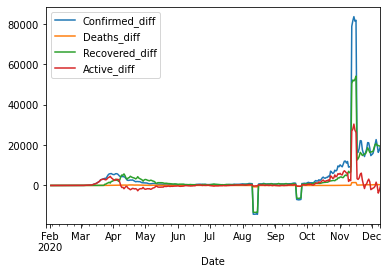

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

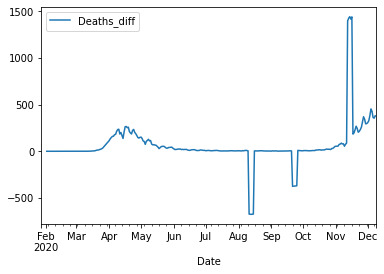

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

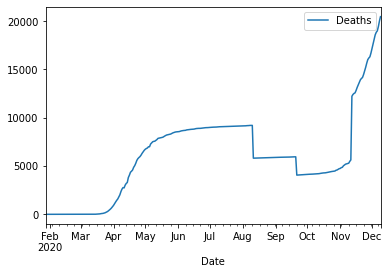

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

In [49]:
display(HTML(covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].to_html()))

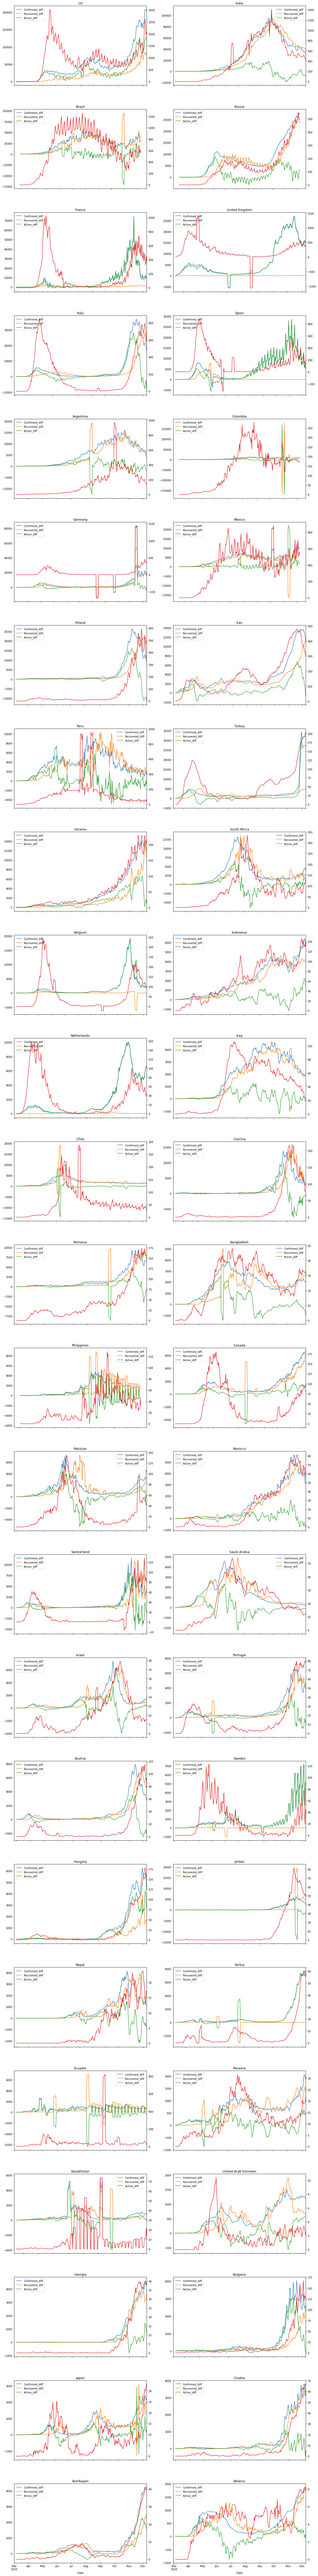

In [50]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)
    ax2=ax.twinx()
    covid.loc[country,['Deaths_diff']].plot(ax=ax2, colormap='Set1')
    ax2.get_legend().remove()
    
fig.subplots_adjust(hspace=0.3)

In [51]:
N_TOP_IMPACTED

50